# Optimize traffic flow with YOLO
Author: Andrii Zapukhlyi

## Objective
Increasing numbers of cars in cities lead to traffic congestion, delays, and inefficient waiting at empty intersections. To address these challenges, many cities are adopting Intelligent Transportation Systems (ITS) for dynamic traffic management. A key component of ITS involves analyzing live CCTV camera feeds at intersections to monitor traffic conditions. However, manual monitoring is impractical and costly. 

AI-based object detection algorithms can automate this process, interpreting camera images to provide real-time data on vehicle counts and traffic flow, enabling more efficient traffic management and reduced delays.

## Solution
To address traffic congestion and optimize flow at intersections, this project will implement an object detection algorithm to analyze images from traffic cameras and extract valuable information for real-time traffic management.

Using a dataset of approximately 6,000 images collected from live cameras positioned at intersections in X City, I will train a YOLO (You Only Look Once) algorithm to detect five classes of objects:

- Car
- Bus
- Bicycle
- Motorbike
- Person

Once trained, the algorithm will be able to accurately identify these objects at intersections. This information will then be used to assess traffic density and determine the optimal timing for switching traffic lights, ultimately reducing idle wait times and improving traffic flow in real time.

## Installing libraries

In [226]:
from ultralytics import YOLO
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [173]:
# For displaying dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)  

## Data overview

<a href = "https://www.kaggle.com/datasets/yusufberksardoan/traffic-detection-project">Link to the dataset</a>

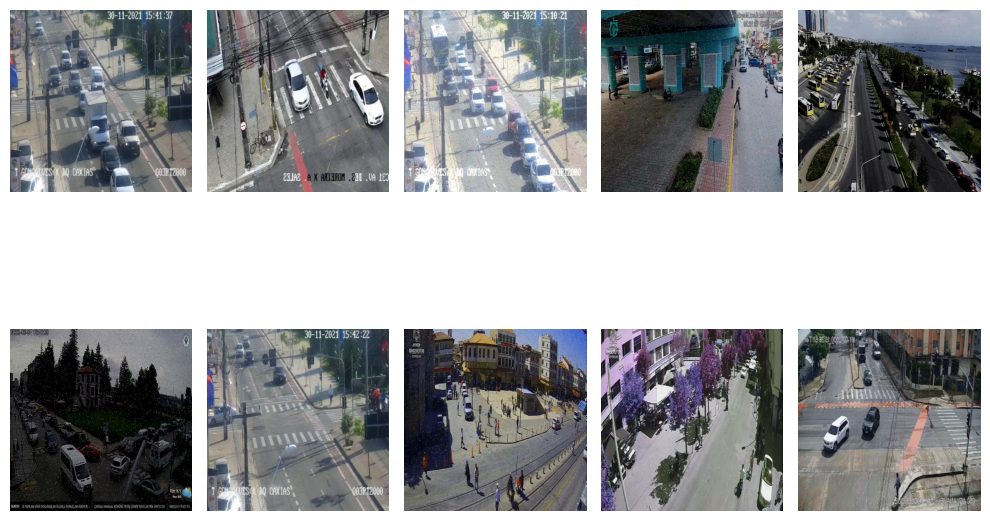

In [174]:
image_folder = "train/images/"
image_files = [f for f in os.listdir(image_folder) if f.endswith(('jpg', 'jpeg', 'png', 'bmp'))]
indexes = np.random.choice(range(len(image_files)), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(10, 8))

for idx, ax in zip(indexes, axes.flatten()):
    img_path = os.path.join(image_folder, image_files[idx])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off') 

plt.tight_layout() 
plt.show()


Above, we can see 10 sample images from the train set. As we can see, dataset was augmented to avoid overfitting

## Data preprocessing

YOLO algorithm from the Ultralytics library already includes built-in image preprocessing steps as part of its pipeline, so I don't have to do it.

The only thing I'll do is create arrays to record the main metrics of the algorithms to use during evaluation.

In [175]:
map50_array = []
f1_array = []
time_training = []

To evaluate the models I will use 3 metrics:
- mAP50@0.5: Mean Average Precision at IoU (Interception over Union) = 0.5. The metric is widely used for evaluating object detection algorithms. Shows how accurately the model detects and localizes objects
- F1 score: the harmonic mean of precision and recall, helping to show the trade-off between these two metrics. Shows the model’s balance in correctly identifying vs missing or over-predicting objects
- Training time of the algorithm

## Validate model function

In [188]:
def validate_model(model, name):
    model_training_process = pd.read_csv(f"models/{name}_training.csv")
    print("Model training process:\n")
    print(model_training_process)
    print("\n")
    time_training.append(model_training_process.iloc[-1,].time)
    model_validation = model.val(data = 'data.yaml', split = "test", verbose = False)
    print("\n")
    map50 = model_validation.results_dict["metrics/mAP50(B)"]
    f1 = (2 * model_validation.results_dict["metrics/precision(B)"] * model_validation.results_dict["metrics/recall(B)"]) / (model_validation.results_dict["metrics/precision(B)"] + model_validation.results_dict["metrics/recall(B)"])

    print(f"{name} results on the test set:")
    print(f"mAP50@0.5: {map50}, F1 score: {f1}")

    map50_array.append(map50)
    f1_array.append(f1)

    return

## Model training

I trained 3 versions of YOLO algorithm: YOLOv3, YOLOv5 and YOLOv8. All models were trained on the cloud with Tesla P100-PCIE-16GB GPU. 

So, I just imported trained models from the .pt files 

In [241]:
# yolo_v3 = YOLO('yolov3.pt')
# yolo_v3.train(data='data.yaml', epochs=10, imgsz=640, batch=16)

# yolo_v5 = YOLO('yolov5l.pt')
# yolo_v5.train(data='data.yaml', epochs=10, imgsz=640, batch=16)

# yolo_v8 = YOLO('yolov8l.pt')
# yolo_v8.train(data='data.yaml', epochs=10, imgsz=640, batch=16)

### YOLO v3

In [190]:
yolo_v3 = YOLO('models/yolo_v3_trained.pt')
validate_model(yolo_v3, "yolo_v3")

Model training process:

   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0    lr/pg1    lr/pg2
0      1   458.662         1.24815         1.05021         1.21481               0.70069            0.66231           0.70718              0.45229       1.14576       0.84362       1.20405  0.000369  0.000369  0.000369
1      2   970.356         1.20427         0.82549         1.19156               0.69006            0.54599           0.59582              0.36176       1.26052       0.97335       1.25925  0.000666  0.000666  0.000666
2      3  1419.860         1.16766         0.75594         1.16411               0.77152            0.70527           0.76357              0.51593       1.09561       0.75275       1.15796  0.000890  0.000890  0.000890
3      4  1869.090         1.11393         0.68398         1.13668               0.77221           

val: Scanning /Users/andrik/DATA/Development/ML/Deep Learning/traffic_detection/test/labels.cache... 279 images, 9 backgrounds, 0 corrupt: 100%|██████████| 279/279 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [13:11<00:00, 43.97s/it]


                   all        279       3188      0.921      0.883       0.93      0.721
Speed: 1.7ms preprocess, 2825.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val


yolo_v3 results on the test set:
mAP50@0.5: 0.9301588320667078, F1 score: 0.9020132498080783


### YOLO v5

In [191]:
yolo_v5 = YOLO('models/yolo_v5_trained.pt')
validate_model(yolo_v5, "yolo_v5")

Model training process:

   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0    lr/pg1    lr/pg2
0      1   329.448         1.27924         1.12014         1.13616               0.69652            0.62271           0.68234              0.43206       1.17741       1.04627       1.09182  0.000369  0.000369  0.000369
1      2   668.585         1.23018         0.86778         1.10722               0.76065            0.66013           0.74338              0.48806       1.14375       0.79946       1.07483  0.000666  0.000666  0.000666
2      3   985.620         1.20527         0.80677         1.09029               0.75685            0.69695           0.76729              0.49827       1.13573       0.77222       1.07578  0.000890  0.000890  0.000890
3      4  1301.740         1.15711         0.74427         1.06810               0.79832           

val: Scanning /Users/andrik/DATA/Development/ML/Deep Learning/traffic_detection/test/labels.cache... 279 images, 9 backgrounds, 0 corrupt: 100%|██████████| 279/279 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [12:45<00:00, 42.55s/it]


                   all        279       3188      0.901      0.874      0.932      0.698
Speed: 1.4ms preprocess, 2734.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val2


yolo_v5 results on the test set:
mAP50@0.5: 0.9317617282025099, F1 score: 0.88748601430967


### YOLO v8

In [192]:
yolo_v8 = YOLO('models/yolo_v8_trained.pt')
validate_model(yolo_v8, "yolo_v8")

Model training process:

   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0    lr/pg1    lr/pg2
0      1   359.182         1.26339         1.07146         1.14955               0.73435            0.63370           0.69432              0.44127       1.16559       1.01898       1.13387  0.000369  0.000369  0.000369
1      2   709.046         1.22096         0.82966         1.13579               0.71898            0.69998           0.73820              0.47529       1.15128       0.78377       1.10956  0.000666  0.000666  0.000666
2      3  1056.960         1.18670         0.76923         1.11204               0.75830            0.73492           0.77868              0.52870       1.10546       0.74377       1.08738  0.000890  0.000890  0.000890
3      4  1404.090         1.13972         0.70838         1.09121               0.82605           

val: Scanning /Users/andrik/DATA/Development/ML/Deep Learning/traffic_detection/test/labels.cache... 279 images, 9 backgrounds, 0 corrupt: 100%|██████████| 279/279 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [12:42<00:00, 42.36s/it]


                   all        279       3188      0.915      0.877      0.934       0.71
Speed: 1.5ms preprocess, 2722.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val3


yolo_v8 results on the test set:
mAP50@0.5: 0.9342387492563052, F1 score: 0.8956767286043252


## Models comparison

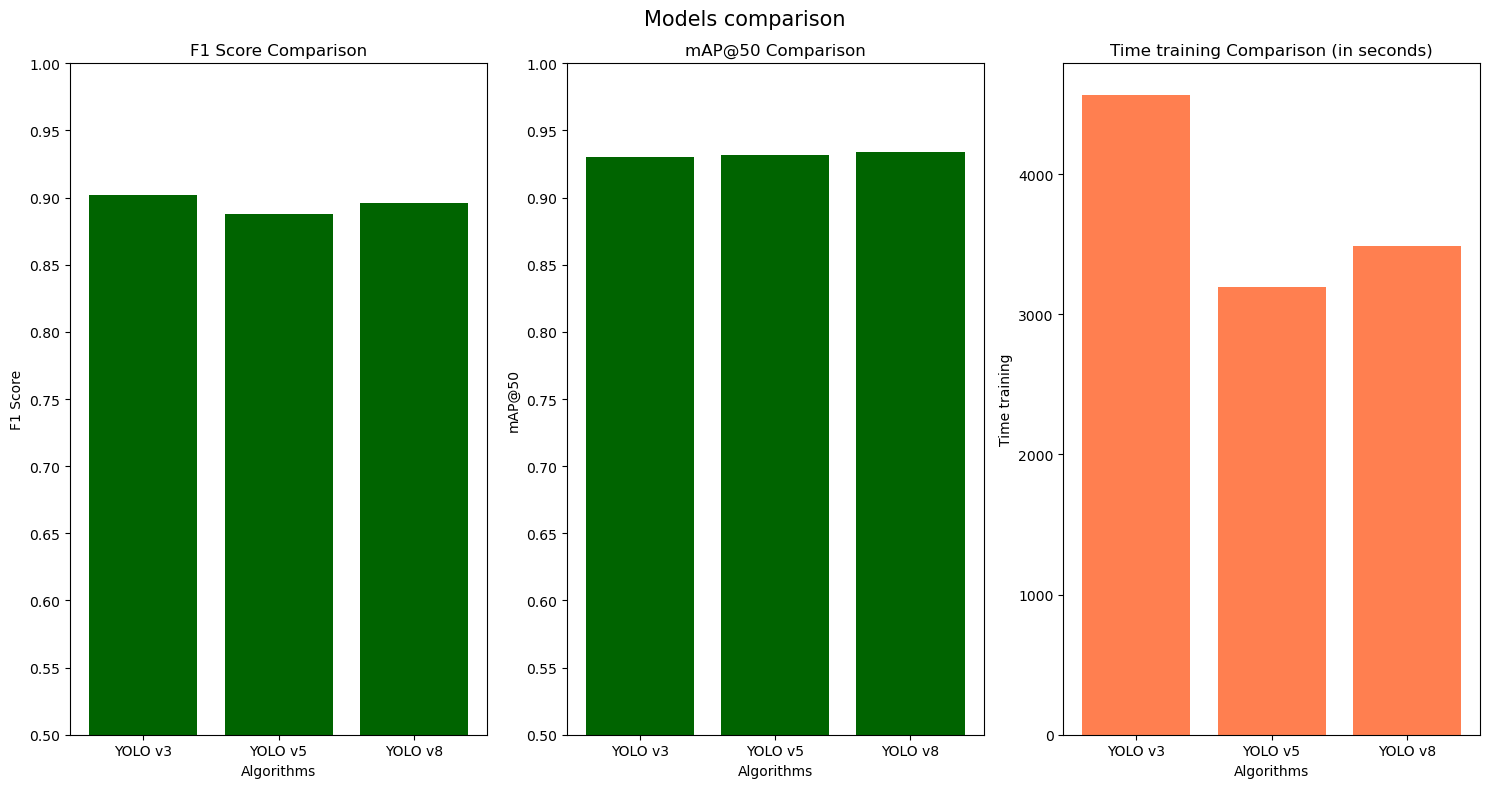

In [202]:
algorithms = ["YOLO v3", "YOLO v5", "YOLO v8"]

fig, axes = plt.subplots(1, 3, figsize=(15, 8))

axes[0].bar(algorithms, f1_array, color='darkgreen')
axes[0].set_title('F1 Score Comparison')
axes[0].set_xlabel('Algorithms')
axes[0].set_ylabel('F1 Score')
axes[0].set_ylim(0.5, 1)
axes[0].set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])

axes[1].bar(algorithms, map50_array, color='darkgreen')
axes[1].set_title('mAP@50 Comparison')
axes[1].set_xlabel('Algorithms')
axes[1].set_ylabel('mAP@50')
axes[1].set_ylim(0.5, 1) 
axes[1].set_yticks([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])

axes[2].bar(algorithms, time_training, color='coral')
axes[2].set_title('Time training Comparison (in seconds)')
axes[2].set_xlabel('Algorithms')
axes[2].set_ylabel('Time training')

plt.suptitle("Models comparison", fontsize=15)
plt.tight_layout()
plt.show()

- YOLOv3 achieved the best F1 score equals 0.90, but it has the longest training time (4563 seconds)

- YOLOv5 has the shortest training time (3198 seconds) with good mAP@50 and F1 scores

- YOLOv8 has the best balance of accuracy and time training. It offers state-of-the-art results with fewer parameters and high accuracy

In summary, YOLOv8 demonstrate the best balance between accuracy and training time

## Visualizations for YOLO v8

### Confusion matrix
<img width="800" height="600" src = "runs/detect/val3/confusion_matrix.png">

As we can see, the primary issue was the model incorrectly detecting cars in areas where no cars were present, essentially classifying background regions as cars.

### F1-Confidence Curve
<img width = "800" heigth = "600" src = "runs/detect/val3/F1_curve.png">

The best overall confidence threshold for maximizing the F1 score across all classes is around 0.450

### Predictions for first batch from the test set
<img width = "800" height = "600" src = "runs/detect/val3/val_batch0_pred.jpg">

## Test prediction on the example from the web

Found https://www.webcamtaxi.com/images/template/thumbs/usa-texas-aquarena.springs-drive.jpg locally at usa-texas-aquarena.springs-drive.jpg


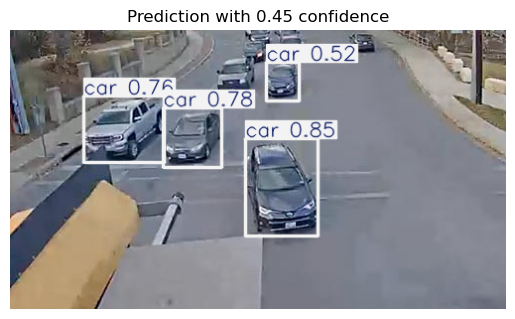

In [240]:
results_test = yolo_v8.predict('https://www.webcamtaxi.com/images/template/thumbs/usa-texas-aquarena.springs-drive.jpg', conf = 0.45)
img = results_test[0].plot()
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Prediction with 0.45 confidence")
plt.show()

## Conclusion

This project showcased the effectiveness of using YOLO algorithms for real-time traffic monitoring. YOLOv3, YOLOv5, and YOLOv8 were evaluated, with YOLOv8 emerging as the best balance between accuracy and training efficiency. Implementing YOLOv8 can enhance traffic flow management by accurately analyzing camera feeds and optimizing signal timings